In [226]:
from unittest import result

import numpy
!pip install onedrivedownloader==1.1.3

In [227]:
import os
import gzip
import numpy as np
import matplotlib.pyplot as plt
from onedrivedownloader import download

download('https://unimore365-my.sharepoint.com/:u:/g/personal/215580_unimore_it/EXhnxAKIfcdIqSRJoFc_C6EBCT6S0CNLOYFW3ShqivC46w?e=Ii4NOp',
                                                      filename='./mnist/mnist_mnist.zip',
                                                      unzip=True)

def load_mnist_digits():
    """
    Loads mnist (original, with digits).

    Returns
    -------
    tuple:
        x_train with shape(n_train_samples, h, w)
        y_train with shape(n_train_samples,)
        x_test with shape(n_test_samples, h, w)
        y_test with shape(n_test_samples,)
    """

    x_train = np.load('mnist/x_train.npy')
    y_train = np.load('mnist/y_train.npy')

    x_test = np.load('mnist/x_test.npy')
    y_test = np.load('mnist/y_test.npy')

    label_dict = {i: str(i) for i in range(0, 10)}

    return x_train, y_train, x_test, y_test, label_dict


def load_mnist(threshold=0.5):
    """
    Loads MNIST data (either digits or fashion) and returns it binarized.

    Parameters
    ----------
    threshold: float
        a threshold in [0, 1] to binarize w.r.t.

    Returns
    -------
    tuple:
        x_train with shape(n_train_samples, h, w)
        y_train with shape(n_train_samples,)
        x_test with shape(n_test_samples, h, w)
        y_test with shape(n_test_samples,)
    """

    x_train, y_train, x_test, y_test, label_dict = load_mnist_digits()

    x_train = np.float32(x_train) / 255.
    x_train[x_train >= threshold] = 1
    x_train[x_train < threshold] = 0

    x_test = np.float32(x_test) / 255.
    x_test[x_test >= threshold] = 1
    x_test[x_test < threshold] = 0

    return x_train, y_train, x_test, y_test, label_dict

Unzipping file...


Extracting files: 100%|██████████| 4/4 [00:00<?, ?it/s]


In [228]:
"""
Class that models a Naive Bayes Classifier
"""

import numpy as np

class NaiveBayesClassifier:
    """
    Naive Bayes Classifier.
    Training:
    For each class, a naive likelihood model is estimated for P(X/Y),
    and the prior probability P(Y) is computed.
    Inference:
    performed according with the Bayes rule:
    P = argmax_Y (P(X/Y) * P(Y))
    or
    P = argmax_Y (log(P(X/Y)) + log(P(Y)))
    """

    def __init__(self):
        """
        Class constructor
        """

        self._classes = None
        self._n_classes = 0

        self._eps = np.finfo(np.float32).eps

        # array of probabilities of a pixel being  1 (for each class)
        self._pixel_probs_given_class = []
        # array of classes prior probabilities
        self._prob_prior_class=[]
        #array of prob per ogni immagine
        self._prob_image_for_every_class=[]
        #array varianza
        self._pixel_std_given_class = []
        #vettore media
        self._medie=[]
        #vettore varianza 
        self._varianze=[]

    def fit(self, X, Y):
        """
        Computes, for each class, a naive likelihood model (self._pixel_probs_given_class),
        and a prior probability (self.class_priors).
        Both quantities are estimated from examples X and Y.

        Parameters
        ----------
        X: np.array
            input MNIST digits. Has shape (n_train_samples, h, w)
            #X e un garande lista di matrici 28x28 in cui ogni matrice e un immagine 
            X = np.array([[1, 2, 3, 4],
              [5, 6, 7, 8],
              [9, 10, 11, 12],
              [13, 14, 15, 16]])
        Y: np.array
            labels for MNIST digits. Has shape (n_train_samples,)
            #Y e una lista di etichette  associate con matrici in X che mi dice a che classe si riferisce
            Y=[0, 1, 0, 1]
        """
        #calcolo media e varianza per  ogni classe 
        for i in range(10):
            #predo tutte img di una classe
            img_class=X[Y==i]
            #calcolo med di i-esima classe, ottengo vettore 784pixel rappresenta la media dei pixel per la i-esima classe da aggiungere alti 
            #in questo self._medie ha una riga per ogni classe con 784 pixel con media questi  idem varianza 
            self._medie.append(np.mean(img_class,axis=0))
            #calcolo la varinaza sostitundo nel caso sia 0 -> 0,01 
            self._varianze.append(np.maximum(np.var(img_class, axis=0), 1e-2))
            #clacolo prior
            self._prob_prior_class.insert(i,(np.sum(Y==i)/np.sum(Y)))
        pass

    def predict(self, X, return_pred=False):
        """
        1)predict parametrica con fromula della gaussiana (calcolando con mda una matrice di cova per ogni classe)
   
        ----------
        X: np.array
            MNIST test images. Has shape (n_test_samples, h, w).

        Returns
        -------
        prediction: np.array
            model predictions over X. Has shape (n_test_samples,)
        """

        #num img
        n_test_img=X.shape[0]
        #reschape X che diventa un vettore 2D con n_test_img righe una per ogni immagine in cui ogni immagine e un solo vettore 1Xnum_pixel_immagine
        X=X.reshape((n_test_img,-1))
        #creo una matrice in cui su ogni riga avrò un immagine e sulle colonne le varie classi e man mano che itero su classi riempio colonne 
        result=np.zeros((n_test_img,10))
        for i in range(10):
            #mat medie pixel
            media_i_pixels=self._medie[i]
            #mat varinze per ogni pixel
            var_i_pixel=self._varianze[i]
            #faccio reshape
            media_i_pixels=media_i_pixels.reshape((1,-1))
            var_i_pixel=var_i_pixel.reshape((1,-1))
            #calocolo prob con gaussiana
            probs=(1/np.sqrt(2*np.pi*(var_i_pixel+self._eps)))*np.exp(-(X-media_i_pixels)**2/(2 * (var_i_pixel+self._eps)))
            #faccio il log della prob
            probs=np.log(probs+self._eps)
            #faccio la somma delle probabilità sulle righe 
            probs=np.sum(probs,axis=1)
            #sommo prob a priori
            probs=probs+np.log(self._prob_prior_class[i]+self._eps)
            #aggiungo prob a result come colonna  per i-esima classe avendo per ogni immagine(riga) la prob che appartenga a classe i
            result[:,i]=probs
            
        
            
        #ritorno il vettore con le previsioni facendo argmax su ogni riga per trovare prob max classe
        return np.argmax(result,axis=1)    
            
            

            
        
            
            
       
                 
    
    @staticmethod
    def _estimate_pixel_probabilities(images):
        """
        [OPTIONAL!]
        Estimates pixel probabilities from data.

        Parameters
        ----------
        images: np.array
            images to estimate pixel probabilities from. Has shape (n_images, h, w)

        Returns
        -------
        pix_probs: np.array
            probabilities for each pixel of being 1, estimated from images.
            Has shape (h, w)
        """
        #creo matrice con somma tutti uno per ogni cella rispetto tutte le immagini
        matr=np.sum(images, axis=0)
        # numero totale di immagini 
        tot_img=images.shape[0]
        #calcolo la matrice di probabilita per ogni pixel dividendo il numero di volte che questo e acceso nelle immagini e num di immagini diponibili
        probmat=matr/tot_img
        #ritorno la matrice con per ogni cella la pobabilità che questa sia a uno ripetto a tutte le immagini che ho
        return probmat

            

    def get_log_likelihood_under_model(self, images, model):
        """
        [OPTIONAL!]
        Returns the likelihood of many images under a certain model.
        Naive:
        the likelihood of the image is the product of the likelihood of each pixel.
        or
        the log-likelihood of the image is the sum of the log-likelihood of each pixel.

        Parameters
        ----------
        images: np.array
            input images. Having shape (n_images, h, w).
        model: np.array
            a model of pixel probabilities, having shape (h, w)

        Returns
        -------
        lkl: np.array
            the likelihood of each pixel under the model, having shape (h, w).
        """
        likelyhoodallimg=[]
        #calcolo matrice likelyhood per ogni immagine
        for img in images:
            martproblikelyhood=img*np.log(model+self._eps)+(1-img)*np.log(1-model+self._eps)
            likelyhoodallimg.append(martproblikelyhood)  
            
        return np.array(likelyhoodallimg)   
        

In [229]:
import numpy as np
import matplotlib.pyplot as plt

x_train, y_train, x_test, y_test, label_dict = load_mnist(threshold=0.5)

print(f"Training set -> number of examples: {len(x_train)}")
print(f"Test set -> number of examples: {len(x_test)}")
print('-'*30)
print(f'X -> shape: {x_train.shape}')
print(f"X -> dtype: {x_train.dtype}")
print(f"X -> min: {x_train.min()}")
print(f"X -> max: {x_train.max()}")
print(f"X -> values: {np.unique(x_train)}")
print('-'*30)
print(f"Classes: {(np.unique(y_train))}")


Training set -> number of examples: 60000
Test set -> number of examples: 10000
------------------------------
X -> shape: (60000, 28, 28)
X -> dtype: float32
X -> min: 0.0
X -> max: 1.0
X -> values: [0. 1.]
------------------------------
Classes: [0 1 2 3 4 5 6 7 8 9]


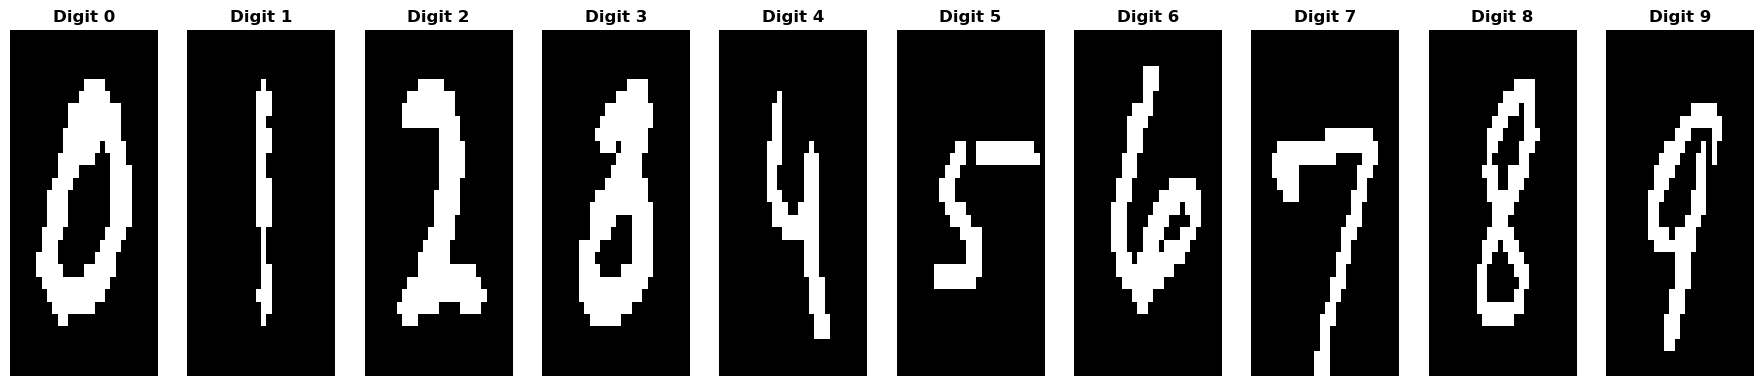

In [230]:
num_row, num_col = 1, 10
len_tr = len(x_train)
f, subplots = plt.subplots(num_row, num_col, sharex='col', sharey='row')

for cls in np.unique(y_train):
    idx = np.arange(len_tr)[y_train == cls]
    idx = np.random.choice(idx)
    X_img = x_train[idx]
    subplots[cls].imshow(X_img, cmap='gray',
                       interpolation='nearest', aspect='auto')
    subplots[cls].set_title(f'Digit {cls}', fontweight="bold")
    subplots[cls].grid(visible=False)
    subplots[cls].axis('off')

f.set_size_inches(22.5, 4.5)

**Step 1: training the Naive Bayes classifier on the training set.**

In [231]:
# get the model
nbc = NaiveBayesClassifier()

# train
nbc.fit(x_train, y_train)

**Step 2: evaluating the performance of the classifier on a set of unseen data (test set).**

Accuracy: 0.7968


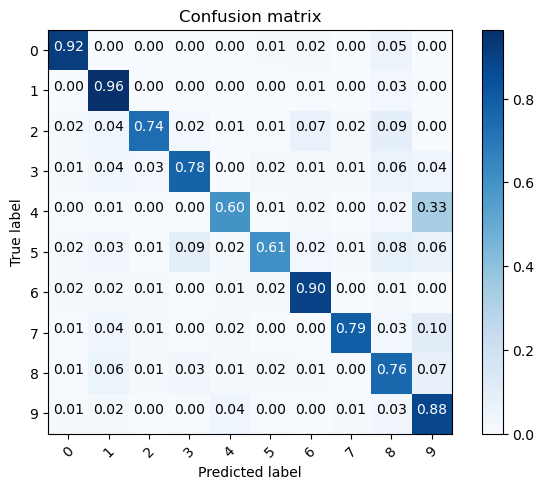

In [232]:
import itertools

def plot_confusion_matrix(targets, predictions, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    n_classes, = np.unique(targets).shape

    cm = np.zeros(shape=(n_classes, n_classes), dtype=np.float32)
    for t, p in zip(targets, predictions):
        cm[int(t), int(p)] += 1

    if normalize:
        cm /= cm.sum(axis=1)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# test
predictions = nbc.predict(x_test.reshape((len(x_test), -1)))

# evaluate performances
accuracy = np.sum(np.uint8(predictions == y_test)) / len(y_test)
print('Accuracy: {}'.format(accuracy))

# show confusion matrix
plot_confusion_matrix(targets=y_test,
                      predictions=predictions,
                      classes=[label_dict[l] for l in label_dict])

Text(0.5, 1.0, 'Target: 8, Prediction: 8')

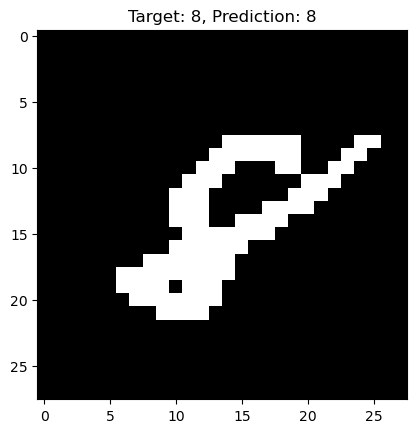

In [233]:
idx = np.random.randint(0, x_test.shape[0])

x = x_test[idx]
p = predictions[idx]
y = y_test[idx]

plt.imshow(x, cmap='gray')
plt.title('Target: {}, Prediction: {}'.format(label_dict[int(y)], label_dict[int(p)]))

In [234]:
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode
import io
from PIL import Image as PILimage

canvas_html = """
<canvas width=256 height=256></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.strokeStyle = "#FFFFFF"
ctx.fillStyle = "#000000";
ctx.fillRect(0, 0, 256, 256)
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}

canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)
  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  ctx.stroke()
}

var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))
  }
})
</script>
"""

def draw(filename='drawing.png', line_width=5, centercrop=True):
  display(HTML(canvas_html % (line_width, )))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  buf = io.BytesIO(binary)
  img = PILimage.open(buf)
  img = img.resize((28, 28), PILimage.BILINEAR)
  img = img.convert('LA')
  img = np.array(img)[:, :, 0]
  img = img > 75

  coords = np.argwhere(img)
  x_min, y_min = coords.min(axis=0)
  x_max, y_max = coords.max(axis=0)
  cropped = img[x_min:x_max+1, y_min:y_max+1]

  out_img = np.zeros((28,28))

  delta_x, delta_y = (28 - cropped.shape[0]) // 2, (28 - cropped.shape[1]) // 2
  out_img[delta_x:delta_x + cropped.shape[0], delta_y :delta_y + + cropped.shape[1]] = cropped

  return out_img.astype(np.float32)

ModuleNotFoundError: No module named 'google'

In [ ]:
img = draw(line_width=10)
print(img.shape, img.dtype, np.unique(img))
plt.imshow(img, cmap='Greys_r')

pred, negllk = nbc.predict(img.reshape(1, 28*28), True)
classes_ord = np.arange(len(np.unique(y_test)))[np.argsort(negllk)]
classes_ord = np.flip(classes_ord)
print(f'Predicted - {pred}')
print(f'Scores: {negllk}')
print(f'Classes ordered by scores: {classes_ord}')